In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [2]:
spark = SparkSession.builder.getOrCreate()

In [5]:
path = "/".join("\sparkdata\DataAnalysisWithPythonAndPySpark-Data\elements".split("\\"))

# pyspark.sql vs. plain SQL

Compared to SQL language, PySpark data manipulation API differs in two ways:
 * PySpark will always start with the name of the dataframe you are working with, while SQL refers to the table used using a FROM keyword
 * PySpark chains the transformations and actions as methods on the data frame, whereas SQL separates them into two group: operation group and condition group

In [6]:
elements = spark.read.csv(
    path + "/Periodic_Table_Of_Elements.csv",
    header=True,
    inferSchema=True,
)

elements.where(F.col("phase") == "liq").groupby("period").count().show()

## In SQL: We assume that the data is in a table called `elements`
    
SELECT
    period,
    count(*)
FROM elements
WHERE phase = 'liq'
GROUP BY period;

+------+-----+
|period|count|
+------+-----+
|     6|    1|
|     4|    1|
+------+-----+



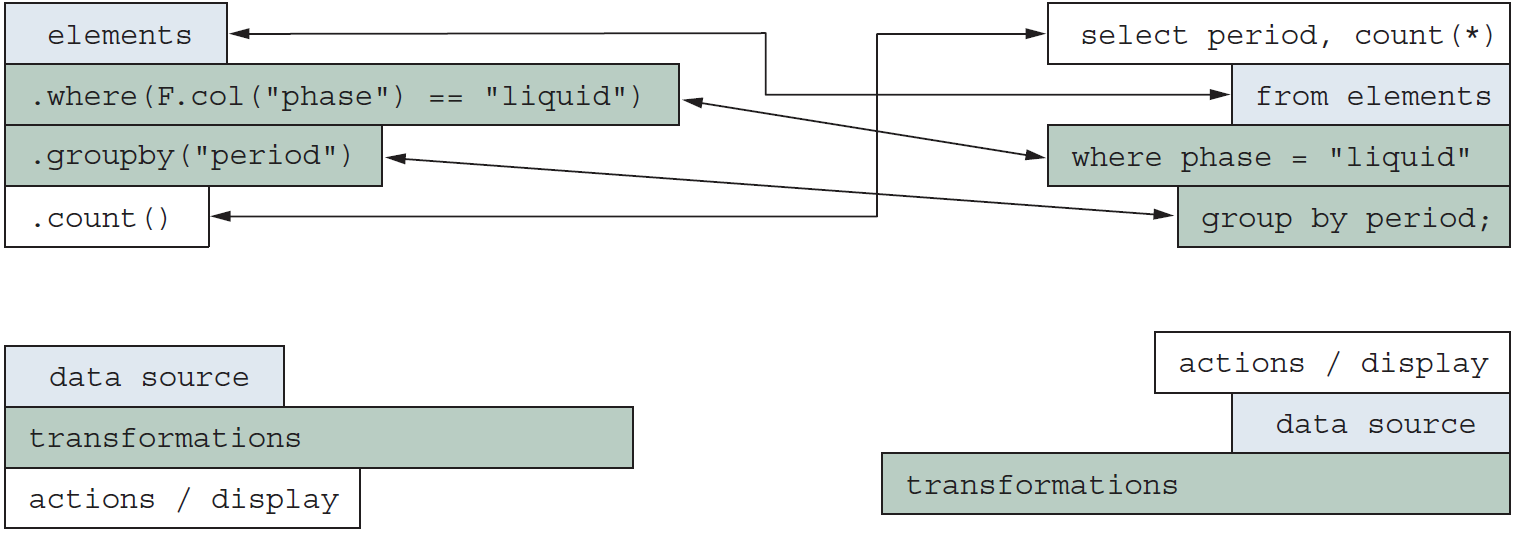

# Preparing a data frame for SQL

Spark provides SQL API. 

### DF to Spark table

When you want to create a table/view to query with Spark SQL, use the _createOrReplaceTempView()_ method.

In [7]:
elements.createOrReplaceTempView("elements")
spark.sql(
    "select period, count(*) from elements where phase='liq' group by period"
).show(5)

+------+--------+
|period|count(1)|
+------+--------+
|     6|       1|
|     4|       1|
+------+--------+



#### PySpark has four methods to create temporary views:

* _createGlobalTempView()_
* _createOrReplaceGlobalTempView()_
* _createOrReplaceTempView()_: replaces old table with new one (if old one exists)
* _createTempView()_: tied with SparkSession

#### To manage Spark SQL tables and views, we use the Spark _catalog_. Catalog manages the metadata of the tables, such as names and level of caching

In [9]:
spark.catalog.listTables()

[Table(name='elements', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

In [10]:
spark.catalog.dropTempView("elements")
spark.catalog.listTables()

[]

# SQL and PySpark

In [ ]:
spark.sql(
    "select serial_number from backblaze_stats_2019 where failure = 1"
).show(
    5
)

#### grouping similar records together: group by and order by


In [ ]:
spark.sql(
    """SELECT
        model,
        min(capacity_bytes / pow(1024, 3)) min_GB,
        max(capacity_bytes/ pow(1024, 3)) max_GB
    FROM backblaze_stats_2019
    GROUP BY 1
    ORDER BY 3 DESC"""
).show(5)

backblaze_2019.groupby(F.col("model")).agg(
    F.min(F.col("capacity_bytes") / F.pow(F.lit(1024), 3)).alias("min_GB"),
    F.max(F.col("capacity_bytes") / F.pow(F.lit(1024), 3)).alias("max_GB"),
).orderBy(F.col("max_GB"), ascending=False).show(5)

#### filtering after grouping using having

In [ ]:
spark.sql(
    """SELECT
        model,
        min(capacity_bytes / pow(1024, 3)) min_GB,
        max(capacity_bytes/ pow(1024, 3)) max_GB
    FROM backblaze_stats_2019
    GROUP BY 1
    HAVING min_GB != max_GB
    ORDER BY 3 DESC"""
).show(5)

backblaze_2019.groupby(F.col("model")).agg(
    F.min(F.col("capacity_bytes") / F.pow(F.lit(1024), 3)).alias("min_GB"),
    F.max(F.col("capacity_bytes") / F.pow(F.lit(1024), 3)).alias("max_GB"),
).where(F.col("min_GB") != F.col("max_GB")).orderBy( ## no difference between having and where in PySpark!
    F.col("max_GB"), ascending=False
).show(
5
)

#### Creating new tables/views using CREATE

In [ ]:
backblaze_2019.createOrReplaceTempView("drive_stats")

spark.sql(
"""
    CREATE OR REPLACE TEMP VIEW drive_days AS
        SELECT model, count(*) AS drive_days
        FROM drive_stats
        GROUP BY model"""
)

spark.sql(
    """CREATE OR REPLACE TEMP VIEW failures AS
        SELECT model, count(*) AS failures
        FROM drive_stats
        WHERE failure = 1
        GROUP BY model"""
)

drive_days = backblaze_2019.groupby(F.col("model")).agg(
    F.count(F.col("*")).alias("drive_days")
)

failures = (
    backblaze_2019.where(F.col("failure") == 1)
    .groupby(F.col("model"))
    .agg(F.count(F.col("*")).alias("failures"))
)


#### Union and Join

In SQL, UNION removes the duplicate records. PySpark’s union() doesn’t, which is
why it’s equivalent to a SQL UNION ALL. __If you want to drop the duplicates, which is
an expensive operation when working in a distributed context__, use the distinct()
function after your union().

Before attempting a union, make sure the daframes have the same columns with the same types in the same order.

In [ ]:
columns_backblaze = ", ".join(q4.columns)

q1.createOrReplaceTempView("Q1")
q2.createOrReplaceTempView("Q2")
q3.createOrReplaceTempView("Q3")
q4.createOrReplaceTempView("Q4")

spark.sql(
    """
    CREATE OR REPLACE TEMP VIEW backblaze_2019 AS
    SELECT {col} FROM Q1 UNION ALL
    SELECT {col} FROM Q2 UNION ALL
    SELECT {col} FROM Q3 UNION ALL
    SELECT {col} FROM Q4
    """.format(
        col=columns_backblaze
    )
)

backblaze_2019 = (
    q1.select(q4.columns)
    .union(q2.select(q4.columns))
    .union(q3.select(q4.columns))
    .union(q4)
)

In [ ]:
spark.sql(
    """select
    drive_days.model,
    drive_days,
    failures
    from drive_days
    left join failures
    on
    drive_days.model = failures.model"""
).show(5)

drive_days.join(failures, on="model", how="left").show(5)

####  CTEs and subqueries

In [ ]:
spark.sql(
    """
    SELECT
        failures.model,
        failures / drive_days failure_rate
    FROM (
        SELECT
            model,
            count(*) AS drive_days
        FROM drive_stats
        GROUP BY model) drive_days
    INNER JOIN (
        SELECT
        model,
        count(*) AS failures
        FROM drive_stats
        WHERE failure = 1
        GROUP BY model) failures
    ON
        drive_days.model = failures.model
    ORDER BY 2 desc
    """
).show(5)

spark.sql(
"""
    WITH drive_days as (
        SELECT
            model,
            count(*) AS drive_days
        FROM drive_stats
        GROUP BY model),
    failures as (
        SELECT
            model,
            count(*) AS failures
        FROM drive_stats
        WHERE failure = 1
        GROUP BY model)
    SELECT
        failures.model,
        failures / drive_days failure_rate
    FROM drive_days
    INNER JOIN failures
    ON
        drive_days.model = failures.model
    ORDER BY 2 desc
"""
).show(5)

In [ ]:
def failure_rate(drive_stats):
    
    drive_days = drive_stats.groupby(F.col("model")).agg(
        F.count(F.col("*")).alias("drive_days")
    )
    
    failures = (
        drive_stats.where(F.col("failure") == 1)
        .groupby(F.col("model"))
        .agg(F.count(F.col("*")).alias("failures"))
    )
    
    answer = (
        drive_days.join(failures, on="model", how="inner")
        .withColumn("failure_rate", F.col("failures") / F.col("drive_days"))
        .orderBy(F.col("failure_rate").desc())
    )
    
    return answer

failure_rate(backblaze_2019).show(5)

print("drive_days" in dir())

#### Blending SQL and Python